Reproduce the MoMi 2023 results from the paper:

- Momi D, Wang Z, Griffiths JD. 2023. TMS-EEG evoked responses are driven by recurrent
  large-scale network dynamics. eLife2023;12:e83232 DOI: https://doi.org/10.7554/eLife.83232

Create a folder named "reproduce_Momi_et_al_2022" in the same directory as this notebook.


1. Download the required data folder at:

https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF

and move the data inside ``reproduce_Momi_et_al_2022`` directory.

2. Download the fsaverage folder at:

https://drive.google.com/drive/folders/1YPyf3h9YKnZi0zRwBwolROQuqDtxEfzF?usp=sharing

and move the `fsaverage` folders inside ``reproduce_Momi_et_al_2022`` directory.


3. Please download the individual leadfield matrix at:

https://drive.google.com/drive/folders/11jOvrzupbm2W8QdKTa9gPeG2Ivk4BdMN?usp=sharing

and replate the path in the ``reproduce_Momi_et_al_2022/leadfield_from_mne`` directory.

In [18]:
import brainunit as u
import numpy as np
import pandas as pd
import scipy

import brainstate
from brainmass.net.jansen_rit import JansenRitNetwork, ModelFitting
from brainmass import Parameter

In [19]:
files_dir = 'D:/codes/githubs/computational_neuroscience/PyTepFit/reproduce_Momi_et_al_2022'
sc_file = files_dir + '/Schaefer2018_200Parcels_7Networks_count.csv'
high_file = files_dir + '/only_high_trial.mat'
dist_file = files_dir + '/Schaefer2018_200Parcels_7Networks_distance.csv'
file_leadfield = files_dir + '/leadfield'
file_eeg = files_dir + '/real_EEG'
eeg = np.load(file_eeg, allow_pickle=True)
eeg

array([[-0.04882562, -0.01855596,  0.0080311 , ...,  0.06746994,
         0.07579786,  0.0950077 ],
       [-0.05753722, -0.04972065, -0.05058948, ...,  0.12024794,
         0.10780556,  0.09364477],
       [-0.04663963, -0.02801384, -0.01127495, ...,  0.07189867,
         0.07543082,  0.08844396],
       ...,
       [ 0.11301994,  0.13689921,  0.15957486, ..., -0.07983613,
        -0.08232486, -0.09218773],
       [ 0.05367654,  0.01649795, -0.01004933, ...,  0.05334642,
         0.02660085, -0.00436937],
       [ 0.01670002, -0.01413833, -0.03701906, ...,  0.04310367,
         0.02319151,  0.0047153 ]])

In [20]:
eeg.shape

(62, 2000)

In [21]:
lm = np.load(file_leadfield, allow_pickle=True)

In [22]:
lm.shape

(62, 200)

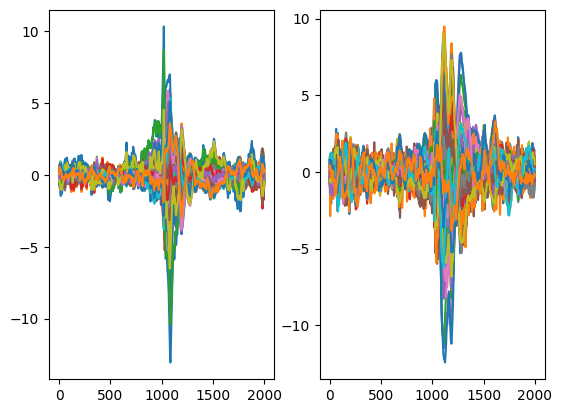

In [23]:
data_high = scipy.io.loadmat(high_file)
# fig, ax = plt.subplots(1, 2)
# ax[0].plot(data_high['only_high_trial'][0].T)
# ax[1].plot(data_high['only_high_trial'][6].T)
# plt.show()

In [24]:
data_high['only_high_trial'].shape

(20, 62, 2000)

In [25]:
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values

sc = 0.5 * (sc + sc.T)
sc = np.log1p(sc) / np.linalg.norm(np.log1p(sc))

In [26]:
sc.shape

(200, 200)

In [27]:
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

In [28]:
dist.shape

(200, 200)

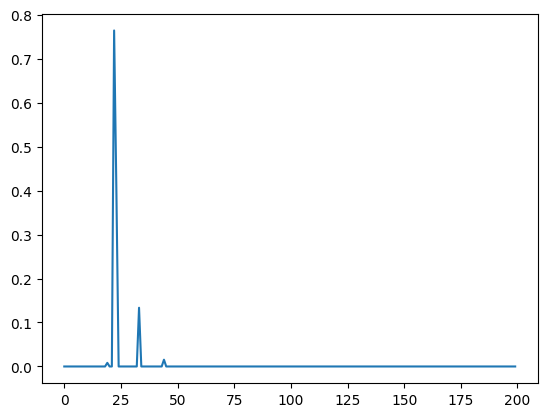

In [29]:
stim_weights_file = files_dir + '/stim_weights.npy'
stim_weights = np.load(stim_weights_file)

# plt.plot(stim_weights)
# plt.show()

In [30]:
stim_weights.shape

(200,)

In [31]:
node_size = stim_weights.shape[0]
output_size = lm.shape[0]
batch_size = 50
input_size = 3
num_epoches = 120
tr = 0.001 * u.second
step_size = 0.0001 * u.second
n_time_per_duration = int(tr / step_size)
lm_v = np.zeros((output_size, node_size))

In [32]:
brainstate.environ.set(dt=step_size)

In [33]:
def train_one_subject(sub_index):
    print(f'sub: {sub_index}')
    data_mean = np.array(data_high['only_high_trial'][sub_index]).T
    # data_mean: [2000, n_channel]
    # data_mean: [2000, 62]

    lm = np.load(f'{files_dir}/leadfield_from_mne/sub{str(sub_index + 1).zfill(3)}/leadfield.npy', allow_pickle=True)
    net = JansenRitNetwork(
        sc=sc,
        lm=brainstate.random.normal(lm, 1.0 / (1.0 + lm_v)),
        w_bb=brainstate.random.normal(sc, 1 / 50.0),
        dist=dist,
        A=3.25,
        a=Parameter(brainstate.random.normal(100., 1 / 0.5)),
        B=22.,
        b=Parameter(brainstate.random.normal(50., 1.0)),
        g=Parameter(brainstate.random.normal(1000., 1 / 0.1)),
        c1=Parameter(brainstate.random.normal(135, 1 / 0.2)),
        c2=Parameter(brainstate.random.normal(135 * 0.8, 1 / 0.4)),
        c3=Parameter(brainstate.random.normal(135 * 0.25, 1 / 0.8)),
        c4=Parameter(brainstate.random.normal(135 * 0.25, 1 / 0.8)),
        std_in=Parameter(brainstate.random.normal(100., 1 / 10.)),
        vmax=5.0,
        v0=6.0,
        r=0.56,
        y0=Parameter(brainstate.random.normal(2.0, 2.0, output_size)),
        mu=Parameter(brainstate.random.normal(1., 1 / 2.5)),
        k=Parameter(brainstate.random.normal(10, 1 / 0.3)),
        cy0=5.0,
        ki=stim_weights,
        fit_gains_flat=True,
    )

    fitter = ModelFitting(
        net,
        optimizer=brainstate.optim.Adam(1e-3),
        duration_per_batch=batch_size * tr,
        time_per_duration=tr,
    )

    # uuu: [n_time, batch_size, node_size]
    uuu = np.zeros((400, n_time_per_duration, node_size))
    uuu[110:120] = 1000
    train_out = fitter.train(data_mean[900:1300], uuu, n_epoch=120)

    uuu = np.zeros((400, n_time_per_duration, node_size))
    uuu[110:120] = 1000
    test_out = fitter.test(data_mean[900:1300], uuu)

    # filename = f'reproduce_fig/sub_{sub_index}_fittingresults_stim_exp.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(fitter, f)
    # outfilename = f'reproduce_fig/sub_{sub_index}_simEEG_stim_exp.pkl'
    # with open(outfilename, 'wb') as f:
    #     pickle.dump({'train': train_out, 'test': test_out}, f)
    #
    # sc_mod = np.zeros((node_size, node_size))
    # mask = np.tril_indices(node_size, -1)
    # sc_mod[mask] = train_out.weights[-10:, :].mean(0)
    # sc_mod = sc_mod + sc_mod.T
    #
    # fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    # ax.imshow(np.log1p(sc_mod), cmap='bwr')
    # plt.show()
    #
    # fig, ax = plt.subplots(1, 3, figsize=(12, 8))
    # ax[0].plot((test_out.E - test_out.I).T)
    # ax[0].set_title('Test: sourced EEG')
    # ax[1].plot(test_out.eeg.T)
    # ax[1].set_title('Test')
    # ax[2].plot(data_high['only_high_trial'][sub_index].T[900:1300, :])
    # ax[2].set_title('empirical')
    # plt.show()

In [34]:
train_one_subject(0)

sub: 0


ValueError: need at least one array to concatenate